# occmodeler tutorial

## Setup the python path

Add `pyspike` to the python path if necessary (this will be streamlined once `occmodeler` is properly packaged)


In [35]:
%load_ext autoreload
%autoreload 2

import plotly.offline as py
import occ
occ.add_pyspike_to_path()
occ.add_occdash_to_path()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
'pyspike' already on python path!
'occdash' already on python path!


## Occasion modeling primitives

### Primitives from WebSci'19 paper
Some of the models built in the WebSci'19 paper act as primitive transitions. These were:

| Model | Primitive | `occ.model.transitions` |
| --- | --- | --- |
| Diffusion | Follow one neighbour | `FollowNeighbour(src, dst, rate)` |
| Diffusion with echo | Follow two neighbours | `FollowTwoNeighbours(src, dst, rate)`
| Issue conflation model | Modulated internal | `ModulatedInternal(src, dst, internal_mod)`

Where `src` is the place in $Unit$ to move a token from and `dst` is the destination place to move it to. These pair highlight the so far un-discussed state-machine type functionality in $Unit$.
`rate` is the $\lambda$ Poisson firing rate in firings per time unit.
`internal_mod` is the place internal to $Unit$ which enambles the internal state transition from `src` to `dst`.

### Creating primitives

The encoding of these transitions is currently made straight to the CANDL file format used by Spike and is not worth describing here. In the future this mapping will be through a coloured Petri net representation and will be presented here. This will allow `occmodeler` users to check existing occasion modeling primitives and to build new ones.




## Building models from primitives

The `occ.model` package contains code for building models at a higher level of abstraction than coloured petri nets.

### Model each repeating unit
The primitives in `occ.model.transitions` just introduced depend on the colour (or type) $Unit$, with which to represent each repeating Unit, and on variables of type $Unit$ with which to label input and output arcs:


In [9]:
import occ.model

unit_colour = occ.model.Color('Unit')

u = unit_colour.var('u')  # Used to identify arcs belonging to am instance of Unit
n1 = unit_colour.var('n1')  # Used to identify a units potential first neighbour
n2 = unit_colour.var('n2')  # Used to identify a units potential second neighbour


A model requires places of color $Unit$. Here the initial markings are set so that units 1 and 2 start in place $a$ and unit 0 starts in place $b$ (we will look at an oftent more convenient way of configuring the initial marking later):

In [10]:
a = unit_colour.place('a', occ.model.marking([1, 2, 3]))
b = unit_colour.place('b', occ.model.marking([0]))



To create a model we include these in a `UnitModel` (there is currently unabstracted complexity here as instances of UnitModel will always required the colour $Unit$ and the variables `u` and `n1`):

In [11]:
m = occ.model.UnitModel(
    name='tutorial - diffusion model',
    colors=[unit_colour],
    variables=[u, n1],
    places=[a, b]
)


To reproduce the simple diffusion model of Figures 3, 4 and 5a, we need only add a single transition from a ($x_0$ in the text) and b ($x_a$) in the text we add a single FollowNeighbour transition from `a` to `b`.


In [12]:
m.add_transition(occ.model.follow1(a, b))


The `add_transition()` method on `UnitModel` will create a place if necessary. It will also check that the colors and variables required for the transition are available.

### Create a medium graph
To create a graph medium with three connected nodes ${n_{1} \longleftrightarrow n_{2} \longleftrightarrow n_{3}}$.


In [13]:
import networkx as nx
medium_graph = nx.Graph([(0, 1), (1, 2), (2, 3)])

Create the system model by embedding the repeating unit on the medium graph:

In [14]:
system_model = occ.model.SystemModel(m, medium_graph, 'four node linear graph')
system_model

SystemModel(unit=<pyspike.model.UnitModel object at 0x121d10940>, network=<networkx.classes.graph.Graph object at 0x121d10be0>, network_name='four node linear graph', marking=None)

- [ ] TODO: `occ.model.SystemModel` takes a name for the graph which should be taken from the graph itself.

## Simulation

The `occ.sim` package contains code for simulating system models.

In [16]:
import occ.sim
sim_args = occ.sim.SimArgs(start=0, stop=10, step=.1, runs=1, repeat_sim=1)
sim_result = occ.sim.run_in_tmp(system_model, sim_args)
sim_result


INFO:root:Using temporary directory:/var/folders/rb/z1vh8mr52xvc_y0yx4bw20jh0000gn/T/tmpa_t351tt
INFO:root:Calling: '['~/bin/spike exe -f input/conf.spc']' from cwd: /var/folders/rb/z1vh8mr52xvc_y0yx4bw20jh0000gn/T/tmpa_t351tt/spike
INFO:root:Call to Spike complete


SimulationResult: temporary run

### Managing simulation runs

Above we used `occ.sim.run_in_tmp()` to run a simulation. This runs Spike up in a tempoary directory, loads the resulting output and returns an `occ.model.SimulationResult`. Alternatively `occ.sim.run_in_dir(a_dir)` will run the simulation in a given directory, which can be useful for debugging.

Most usefully, `occ.sim.run()`, will create a sequentially numbered list of directories for each run within a `basedir`. `basedir` defaults to the top level of the occmodeler repository for now:


In [38]:
print(occ.sim.BASEDIR)
occ.sim.run(system_model, sim_args)

INFO:root:Calling: '['~/bin/spike exe -f input/conf.spc']' from cwd: /Users/walton/Documents/DPhil/code/occmodeller/runs/21/spike


/Users/walton/Documents/DPhil/code/occmodeller/runs


INFO:root:Call to Spike complete


SimulationResult: run['num']=21. http://127.0.0.1:8050/run-21

Finally, if you've used `occ.sim.run_in_tmp()` and seen something interesting the results may be archived by calling `occ.save(sim_result)`, and you load results with `occ.sim.load(run_num)`

## Simulation results

The scans above return `occ.sim.SimulationResult` object.

### Raw time series data
A time series of place counts and transitions are loaded as pandas data frames:

In [18]:
(sim_result.raw_places).sort_index(axis=1).head()

,Time,a,a_0,a_1,a_2,a_3,b,b_0,b_1,b_2,b_3
0,0.0,3,0,1,1,1,1,1,0,0,0
1,0.1,3,0,1,1,1,1,1,0,0,0
2,0.2,3,0,1,1,1,1,1,0,0,0
3,0.3,3,0,1,1,1,1,1,0,0,0
4,0.4,3,0,1,1,1,1,1,0,0,0


In [19]:
(sim_result.raw_transitions).sort_index(axis=1).head()

,Time,f1ab,f1ab_0_1,f1ab_1_0,f1ab_1_2,f1ab_2_1,f1ab_2_3,f1ab_3_2
0,0.0,0,0,0,0,0,0,0
1,0.1,0,0,0,0,0,0,0
2,0.2,0,0,0,0,0,0,0
3,0.3,0,0,0,0,0,0,0
4,0.4,0,0,0,0,0,0,0


### Tidy time series data
The `occ.sim.SimulationResult` also include the place and transition data in [tidy](https://en.wikipedia.org/wiki/Tidy_data) form:

In [20]:
(sim_result.places).head()

,tstep,time,type,name,num,count
100,0,0.0,place,a,3.0,1
101,1,0.1,place,a,3.0,1
102,2,0.2,place,a,3.0,1
103,3,0.3,place,a,3.0,1
104,4,0.4,place,a,3.0,1


In [21]:
(sim_result.transitions).head()

,tstep,time,type,name,unit,neighbour,neighbour2,count
100,0,0.0,transition,f1ab,2.0,1.0,NaN,0
101,1,0.1,transition,f1ab,2.0,1.0,NaN,0
102,2,0.2,transition,f1ab,2.0,1.0,NaN,0
103,3,0.3,transition,f1ab,2.0,1.0,NaN,0
104,4,0.4,transition,f1ab,2.0,1.0,NaN,0


## Data reduction
The `occ.reduction` package includes functions for loading and reducing the data from a simulation run.

In [22]:
import occ.reduction
place_change_events = occ.reduction.generate_place_increased_events(sim_result.places)
place_change_events

,tstep,time,type,name,num
200,0,0.0,place,a,1
400,0,0.0,place,a,2
100,0,0.0,place,a,3
600,0,0.0,place,b,0
709,9,0.9,place,b,1
810,10,1.0,place,b,2
314,14,1.4,place,b,3


In [23]:
transition_events = occ.reduction.generate_transition_events(sim_result.transitions)
transition_events

,tstep,time,type,name,unit,neighbour,neighbour2,count
409,9,0.9,transition,f1ab,1.0,0.0,NaN,1
110,10,1.0,transition,f1ab,2.0,1.0,NaN,1
514,14,1.4,transition,f1ab,3.0,2.0,NaN,1


## Visualisation

### Occasion graph

Create an causal occasion graph and plot in 2d and then 3d.

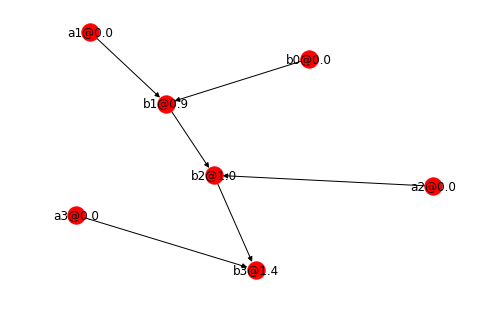

In [32]:
occasion_graph = occ.reduction.generate_causal_graph(
        place_change_events, transition_events, time_per_step=sim_result.sim_args.step)

import networkx as nx
nx.draw(occasion_graph, with_labels=True)

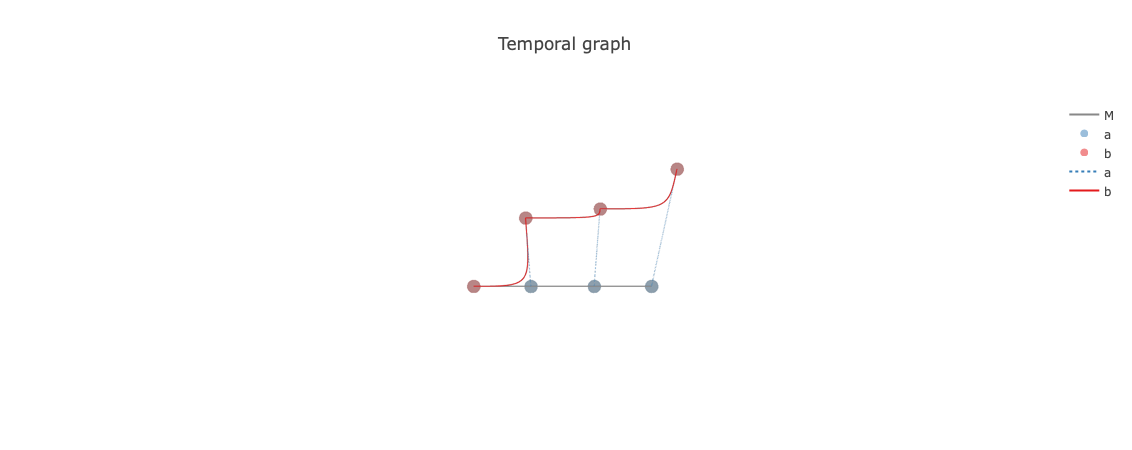

In [36]:
py.iplot(g)

## visualise with `occdash`

View and interact with simulation results. This only works with simulations that have been archived in the run folder (see above).

Expects redis to be running on port 6379 for caching. Start using:

    $ redis-server
    
Start the dash application (from occmodeler repo dir):

    $ python path/to/occdash/app.py
    
To view a particular run use http://127.0.0.1:8050/run-1 . To view the last run (collected to `occ.sim.BASEDIR`) open http://127.0.0.1:8050/run-last and reload to update. Note that `occ.sim.run()` will trigger a reload of occdash if it is open. It does this by calling `occdash.manage.reload_dash_server()` which uses a very heavy handed way to hot re-serve the page and force the client to reload.
   
Dash sometimes gets stuck running in the background. This alias is useful to kill it:
 
    alias killdash='kill -9 `lsof -i:8050 -t`'
